In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import shap
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('train.csv')
df_train = df[(df['stock_id']<=50)]
df_test = df[(df['stock_id']==51)]
df_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237826,46,480,540,828199.45,-1,0.998231,10381374.33,0.995762,0.996749,0.998231,23128.82,0.998477,240890.42,0.998252,-2.679825,26454,480_540_46
5237827,47,480,540,605273.42,-1,0.999177,9039036.76,0.997094,0.998362,0.999177,59551.20,0.999268,33197.29,0.999236,-4.770160,26454,480_540_47
5237828,48,480,540,3390148.90,1,1.000073,28556691.76,1.000702,1.000702,0.999983,66978.52,1.000118,66987.55,1.000051,4.169941,26454,480_540_48
5237829,49,480,540,452208.02,1,1.001097,15719473.06,1.001851,1.001474,1.000720,424029.58,1.001097,184655.25,1.000983,-1.369715,26454,480_540_49


In [35]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

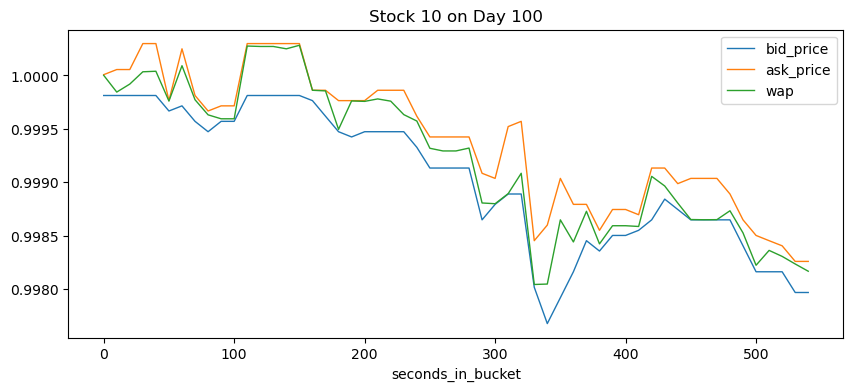

In [18]:
time_series_plot(
    df=df_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 10,
    date_id = 100
)

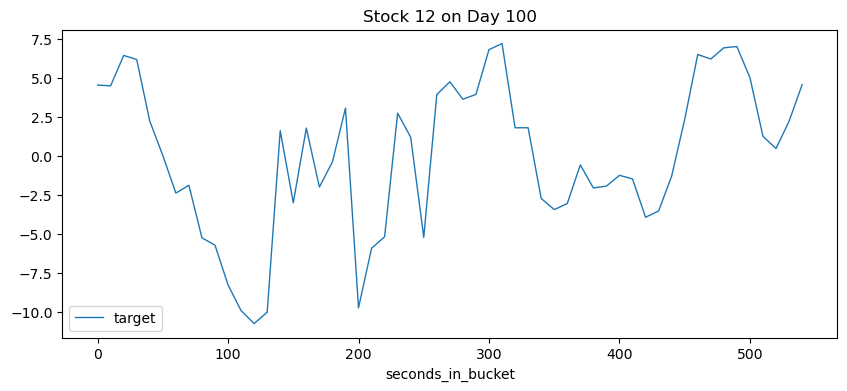

In [23]:
time_series_plot(
    df=df_train, 
    cols=['target'], 
    stock_id = 12,
    date_id = 100
)

In [4]:
df_train = df_train.dropna(subset=["target"])
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)

df_test = df_test.dropna(subset=["target"])
df_test.reset_index(drop=True, inplace=True)
print(df_test.shape)

X_train = df_train.loc[:, df_train.columns!="target"]
y_train = df_train["target"]
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_test = df_test.loc[:, df_test.columns!="target"]
y_test = df_test["target"]
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

(1349204, 17)
(26455, 17)
X_train shape: (1349204, 16)
y_train shape: (1349204,)
X_test shape: (26455, 16)
y_test shape: (26455,)


In [5]:
def handle_missing_values(X,y=None):

    ftrs1 = ['far_price','near_price']
    ftrs2 = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price',\
              'bid_price', 'ask_price', 'wap']
    
    X_filled = X.copy() 
    
    for ftr in ftrs1:
        X_filled.loc[(X['seconds_in_bucket'] < 300) & (X[ftr].isna()), ftr] = 0
    
    for ftr in ftrs2:
        X_filled.loc[X_filled['seconds_in_bucket'] != 0, ftr] = X_filled.loc[X_filled['seconds_in_bucket'] != 0, ftr].ffill()
        X_filled.loc[X_filled['seconds_in_bucket'] == 0, ftr] = X_filled.loc[X_filled['seconds_in_bucket'] == 0, ftr].bfill()
    
    y_filled = y.ffill()
    
    # print('data dimensions:',X_filled.shape)
    # perc_missing_per_ftr = X_filled.isnull().sum(axis=0)/X_filled.shape[0]
    # print('fraction of missing values in features:')
    # print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

    # print('data dimensions:',y_filled.shape)
    # perc_missing_per_ftr = y_filled.isnull().sum(axis=0)/y_filled.shape[0]
    # print('fraction of missing values in features:')
    # print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

    return X_filled, y_filled

In [6]:
def feature_engineering(X):

    median_vol = X.groupby('stock_id')['bid_size'].median() + X.groupby('stock_id')['ask_size'].median()
    X['imb_s1'] = X.eval('(bid_size-ask_size)/(bid_size+ask_size)').astype(np.float32)
    X['imb_s2'] = X.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)').astype(np.float32)
    X['bid_plus_ask_sizes'] = X['bid_size'] + X['ask_size']
    X['median_vol'] = X['stock_id'].map(median_vol.to_dict())
    X['high_volume'] = np.where(X['bid_plus_ask_sizes'] > X['median_vol'], 1, 0) 
    X['imbalance_ratio'] = X['imbalance_size'] / X['matched_size']
    X['ask_x_size'] = X.eval('ask_size*ask_price')
    X['bid_x_size'] = X.eval('bid_size*bid_price')
    X['ask_minus_bid'] = X['ask_x_size'] - X['bid_x_size'] 
    X["bid_size_over_ask_size"] = X["bid_size"].div(X["ask_size"])
    X["bid_price_over_ask_price"] = X["bid_price"].div(X["ask_price"])

    X['time_diff'] = X.groupby('stock_id')['date_id'].diff().fillna(0)
    lags = [1, 2, 5, 10, 20, 30]
    grouped = X.groupby('stock_id')
    for lag in lags:
        df[f'imb_s1_{lag}'] = grouped['imb_s1'].shift(lag)
        df[f'imb_s2_{lag}'] = grouped['imb_s2'].shift(lag)

    X['imbalance_size_rolling_mean_10'] = grouped['imbalance_size'].rolling(window=10).mean().reset_index(0, drop=True)
    X['imbalance_size_rolling_std_10'] = grouped['imbalance_size'].rolling(window=10).std().reset_index(0, drop=True)
    X['imbalance_size_rolling_mean_5'] = grouped['imbalance_size'].rolling(window=5).mean().reset_index(0, drop=True)
    X['imbalance_size_rolling_std_5'] = grouped['imbalance_size'].rolling(window=5).std().reset_index(0, drop=True)
    X['imbalance_ratio'] = grouped['imbalance_size'].apply(lambda x: x.where(x > 0).sum() / x.where(x < 0).sum())

    X['bid_ask_spread'] = X['ask_price'] - X['bid_price']
    X['bid_ask_spread_change'] = X['bid_ask_spread'].diff()

    X['price_change_1s'] = grouped['wap'].diff(1)
    X['price_change_5s'] = grouped['wap'].diff(5)
    X['price_change_10s'] = grouped['wap'].diff(10)
    X['price_change_60s'] = grouped['wap'].diff(60)

    X['vwap'] = grouped.apply(lambda x: np.sum(x['wap'] * x['matched_size']) / np.sum(x['matched_size']))
    
    X['volatility_10s'] = grouped['wap'].rolling(window=10).std().reset_index(0, drop=True)
    X['volatility_30s'] = grouped['wap'].rolling(window=10).std().reset_index(0, drop=True)
    X['volatility_60s'] = grouped['wap'].rolling(window=60).std().reset_index(0, drop=True)

    X['is_first_240_seconds'] = (df['seconds_in_bucket'] < 240).astype(int)
    
    X['price_momentum_50'] = (grouped['wap'].pct_change(50) + 1).cumprod() - 1
    X['price_momentum_30'] = (grouped['wap'].pct_change(30) + 1).cumprod() - 1
    X['price_momentum_10'] = (grouped['wap'].pct_change(10) + 1).cumprod() - 1

    # X.fillna(0, inplace=True)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X = X.fillna(0)

    cols = [c for c in X.columns if c not in ['stock_id', 'row_id', 'time_id', 'date_id']]
    X = X[cols]

    print('data dimensions:',X.shape)
    print("Number of NaN values after replacement:", X.isna().sum().sum())
    
    return X
    

In [7]:
# data without feature engineering
X_train_0, y_train_0 = handle_missing_values(X_train, y_train)
cols = [c for c in X_train_0.columns if c not in ['stock_id', 'row_id', 'time_id', 'date_id']]
X_train_0 = X_train_0[cols]

X_test_0, y_test_0 = handle_missing_values(X_test, y_test)
cols = [c for c in X_test_0.columns if c not in ['stock_id', 'row_id', 'time_id', 'date_id']]
X_test_0 = X_test_0[cols]

In [8]:
print('Training data:')
X_train_1, y_train_1 = handle_missing_values(X_train, y_train)
X_train_1 = feature_engineering(X_train_1)
print('\n')
print('Testing data:')
X_test_1, y_test_1 = handle_missing_values(X_test, y_test)
X_test_1 = feature_engineering(X_test_1)

Training data:


divide by zero encountered in scalar divide


data dimensions: (1349204, 42)
Number of NaN values after replacement: 0


Testing data:
data dimensions: (26455, 42)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


In [9]:
df_train_2 = df[(df['stock_id']<=51)&(df['stock_id']>=1)]
df_test_2 = df[(df['stock_id']<1)]

df_train_2 = df_train_2.dropna(subset=["target"])
df_train_2.reset_index(drop=True, inplace=True)

df_test_2 = df_test_2.dropna(subset=["target"])
df_test_2.reset_index(drop=True, inplace=True)

X_train_2 = df_train_2.loc[:, df_train_2.columns!="target"]
y_train_2 = df_train_2["target"]

X_test_2 = df_test_2.loc[:, df_test_2.columns!="target"]
y_test_2 = df_test_2["target"]

X_train_2, y_train_2 = handle_missing_values(X_train_2, y_train_2)
X_train_2 = feature_engineering(X_train_2)

X_test_2, y_test_2 = handle_missing_values(X_test_2, y_test_2)
X_test_2 = feature_engineering(X_test_2)

divide by zero encountered in scalar divide


data dimensions: (1349204, 54)
Number of NaN values after replacement: 0
data dimensions: (26455, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


In [10]:
df_train_3 = df[(df['stock_id']<=51)]
df_train_3 = df_train_3[(df_train_3['stock_id']<25)|(df_train_3['stock_id']>25)]
df_test_3 = df[(df['stock_id']==25)]

df_train_3 = df_train_3.dropna(subset=["target"])
df_train_3.reset_index(drop=True, inplace=True)

df_test_3 = df_test_3.dropna(subset=["target"])
df_test_3.reset_index(drop=True, inplace=True)

X_train_3 = df_train_3.loc[:, df_train_3.columns!="target"]
y_train_3 = df_train_3["target"]

X_test_3 = df_test_3.loc[:, df_test_3.columns!="target"]
y_test_3 = df_test_3["target"]

X_train_3, y_train_3 = handle_missing_values(X_train_3, y_train_3)
X_train_3 = feature_engineering(X_train_3)

X_test_3, y_test_3 = handle_missing_values(X_test_3, y_test_3)
X_test_3 = feature_engineering(X_test_3)

divide by zero encountered in scalar divide


data dimensions: (1349204, 54)
Number of NaN values after replacement: 0
data dimensions: (26455, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


## Baseline Model

In [11]:
bl_test_pred = []
bl_test_scores = []

In [12]:
from sklearn.metrics import mean_absolute_error

y_pred_0 = pd.Series(np.zeros(len(y_train)), index=y_train.index)
y_pred_0_test = pd.Series(np.zeros(len(y_test)), index=y_test.index)

mae_baseline = mean_absolute_error(y_train_1, y_pred_0)
print("Baseline MAE (Training) 0:", mae_baseline)
mae_baseline = mean_absolute_error(y_test_1, y_pred_0_test)
print("Baseline MAE (Testing) 0:", mae_baseline)
bl_test_pred.append(y_pred_0_test)
bl_test_scores.append(mae_baseline)

mae_baseline = mean_absolute_error(y_train_2, y_pred_0)
print("Baseline MAE (Training) 1:", mae_baseline)
mae_baseline = mean_absolute_error(y_test_2, y_pred_0_test)
print("Baseline MAE (Testing) 1:", mae_baseline)
bl_test_pred.append(y_pred_0_test)
bl_test_scores.append(mae_baseline)

mae_baseline = mean_absolute_error(y_train_3, y_pred_0)
print("Baseline MAE (Training) 2:", mae_baseline)
mae_baseline = mean_absolute_error(y_test_3, y_pred_0_test)
print("Baseline MAE (Testing) 2:", mae_baseline)
bl_test_pred.append(y_pred_0_test)
bl_test_scores.append(mae_baseline)

Baseline MAE (Training) 0: 6.0475529512241355
Baseline MAE (Testing) 0: 8.416682551080816
Baseline MAE (Training) 1: 6.126732587673073
Baseline MAE (Testing) 1: 4.378524085178189
Baseline MAE (Training) 2: 6.11104732024428
Baseline MAE (Testing) 2: 5.178472131142997


## Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [16]:
X_train_all = [X_train_1, X_train_2, X_train_3]
y_train_all = [y_train_1, y_train_2, y_train_3]
X_test_all = [X_test_1, X_test_2, X_test_3]
y_test_all = [y_test_1, y_test_2, y_test_3]

In [17]:
lr_test_pred = []
lr_test_scores = []

for i in range(3):
    X_train_temp = X_train_all[i]
    y_train_temp = y_train_all[i]
    X_test_temp = X_test_all[i]
    y_test_temp = y_test_all[i]

    model_lr = LinearRegression()
    model_lr.fit(X_train_temp,y_train_temp)
    y_pred_lr = model_lr.predict(X_train_temp)
    y_pred_lr_test = model_lr.predict(X_test_temp)

    mae_lr_train = mean_absolute_error(y_train_temp, y_pred_lr)
    print(f"Linear Regression MAE (Training) {i}:", mae_lr_train)
    mae_lr_test = mean_absolute_error(y_test_temp, y_pred_lr_test)
    print(f"Linear Regression MAE (Testing) {i}:", mae_lr_test)

    lr_test_pred.append(y_pred_lr_test)
    lr_test_scores.append(mae_lr_test)

Linear Regression MAE (Training) 0: 5.942985708076664
Linear Regression MAE (Testing) 0: 8.342784285932435
Linear Regression MAE (Training) 1: 6.02113812796994
Linear Regression MAE (Testing) 1: 4.354256472260101
Linear Regression MAE (Training) 2: 6.00644675549789
Linear Regression MAE (Testing) 2: 5.10517217551856


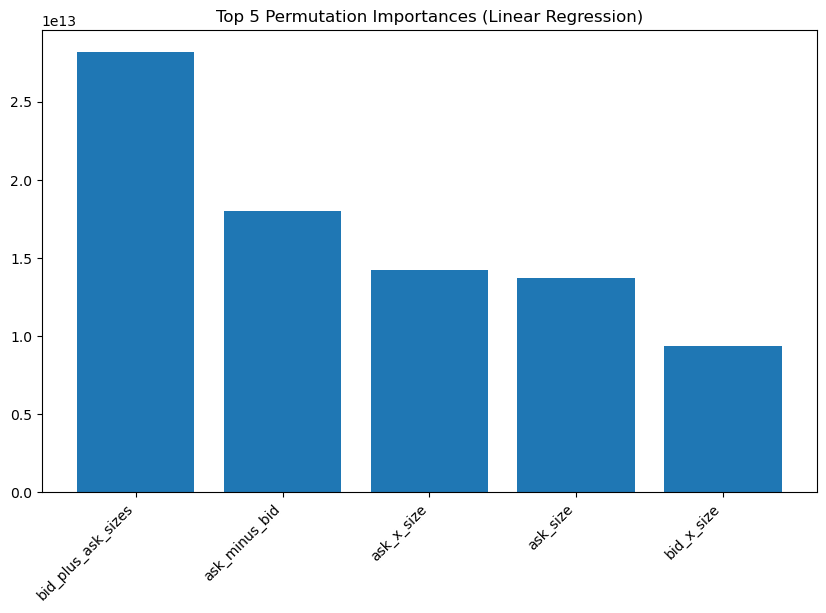

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Now, calculate permutation importances
result = permutation_importance(model_lr, X_train_temp, y_train_temp, n_repeats=10, random_state=42)

# Get feature importances and their indices
feature_importances = result.importances_mean
feature_indices = np.argsort(feature_importances)[::-1]

# Select the top 5 features
top_n = 5
top_feature_indices = feature_indices[:top_n]
top_feature_importances = feature_importances[top_feature_indices]

# Plot permutation importances for the top 5 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_feature_importances)
plt.xticks(range(top_n), X_train_temp.columns[top_feature_indices], rotation=45, ha="right")
plt.title("Top 5 Permutation Importances (Linear Regression)")
plt.show()


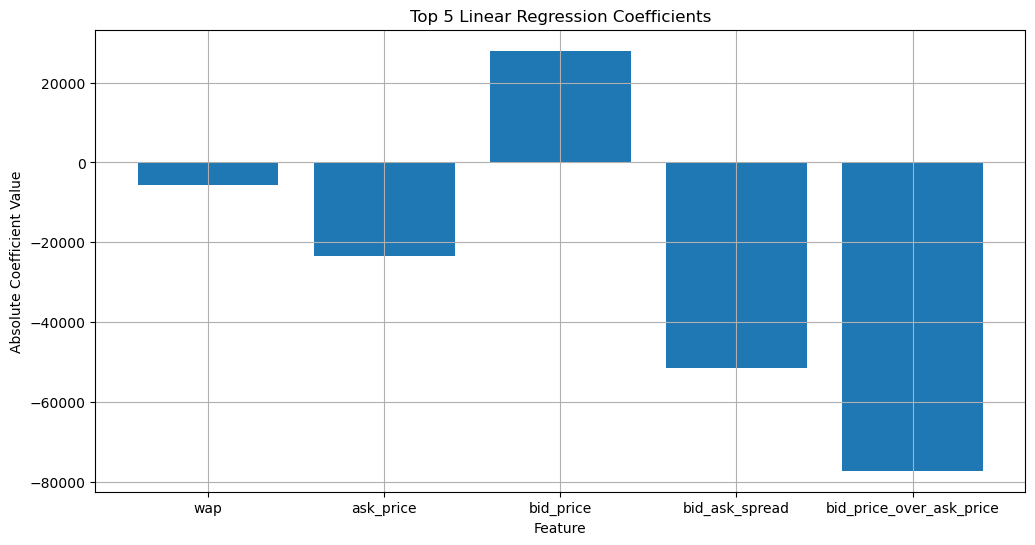

In [30]:
top_features = np.argsort(np.abs(model_lr.coef_))[-5:]

# Plot coefficients for the top 5 features
plt.figure(figsize=(12, 6))
plt.bar(X_train_temp.columns[top_features], model_lr.coef_[top_features])

plt.title('Top 5 Linear Regression Coefficients')
plt.xlabel('Feature')
plt.ylabel('Absolute Coefficient Value')
plt.grid(True)
plt.show()

In [123]:

model_lr = LinearRegression()
model_lr.fit(X_train_1,y_train_1)
y_pred_lr = model_lr.predict(X_train_1)
y_pred_lr_test = model_lr.predict(X_test_1)

mae_lr_train = mean_absolute_error(y_train_1, y_pred_lr)
print("Linear Regression MAE (Training):", mae_lr_train)
mae_lr_test = mean_absolute_error(y_test_1, y_pred_lr_test)
print("Linear Regression MAE (Testing):", mae_lr_test)

Linear Regression MAE (Training): 5.942985708076664
Linear Regression MAE (Testing): 8.342784285932435


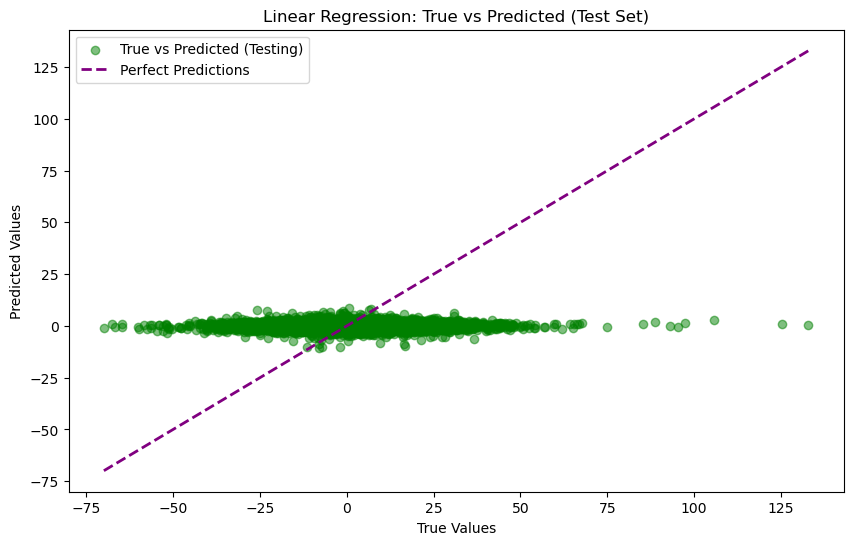

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_1, y_pred_lr_test, color='green', alpha=0.5, label='True vs Predicted (Testing)')
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], color='purple', linestyle='--', linewidth=2, label='Perfect Predictions')
plt.title('Linear Regression: True vs Predicted (Test Set)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

### Linear Regression without feature engineering

In [121]:
model_1_lr = LinearRegression()
model_1_lr.fit(X_train_0,y_train_0)
y_pred_1_lr = model_1_lr.predict(X_train_0)
y_pred_1_lr_test = model_1_lr.predict(X_test_0)

mae_1_lr_train = mean_absolute_error(y_train_0, y_pred_1_lr)
print("Linear Regression MAE (Training):", mae_1_lr_train)
mae_1_lr_test = mean_absolute_error(y_test_0, y_pred_1_lr_test)
print("Linear Regression MAE (Testing):", mae_1_lr_test)

Linear Regression MAE (Training): 5.947857457649628
Linear Regression MAE (Testing): 8.34466156013407


## Xgboost

In [20]:
df_train_train = df_train[(df_train['stock_id']<=40)]
df_train_val = df_train[(df_train['stock_id']>40)]

X_train_train = df_train_train.loc[:, df_train_train.columns!="target"]
y_train_train = df_train_train["target"]
X_train_val = df_train_val.loc[:, df_train_val.columns!="target"]
y_train_val = df_train_val["target"]

X_train_train, y_train_train = handle_missing_values(X_train_train, y_train_train)
X_train_train = feature_engineering(X_train_train)

X_train_val, y_train_val = handle_missing_values(X_train_val, y_train_val)
X_train_val = feature_engineering(X_train_val)

divide by zero encountered in scalar divide


data dimensions: (1084654, 42)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (264550, 42)
Number of NaN values after replacement: 0


In [21]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_train, label=y_train_train)
dval = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test_1, label=y_test_1)

params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'mae',  # Use MAE as the evaluation metric
    'max_depth': 6,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1  # L1 regularization term (lasso)
}

num_boost_round = 1000
early_stopping_rounds = 10

model = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dval, 'valid')],
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=False)

y_pred = model.predict(dtrain)
mae = mean_absolute_error(y_train_train, y_pred)
print("XGBoost MAE (Train):", mae)

y_pred = model.predict(dval)
mae = mean_absolute_error(y_train_val, y_pred)
print("XGBoost MAE (Val):", mae)

y_pred = model.predict(dtest)
mae = mean_absolute_error(y_test_1, y_pred)
print("XGBoost MAE (Test):", mae)

XGBoost MAE (Train): 5.974003329031213
XGBoost MAE (Val): 5.8510996512118965
XGBoost MAE (Test): 8.362325095384094


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


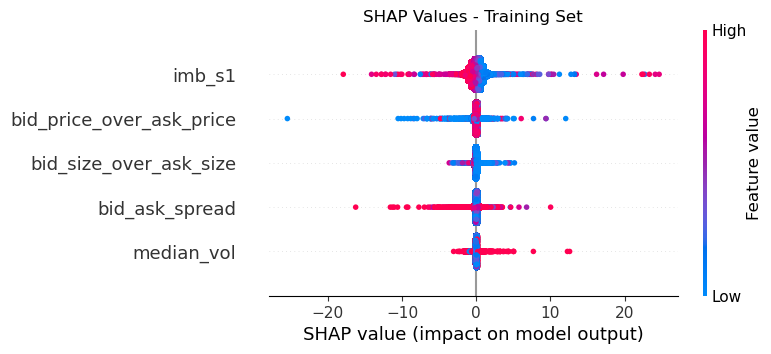

In [23]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_train)

# Summary plot of SHAP values for the training set
shap.summary_plot(shap_values_train, X_train_train, feature_names=X_train_train.columns, max_display=5, show=False)
plt.title("SHAP Values - Training Set")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


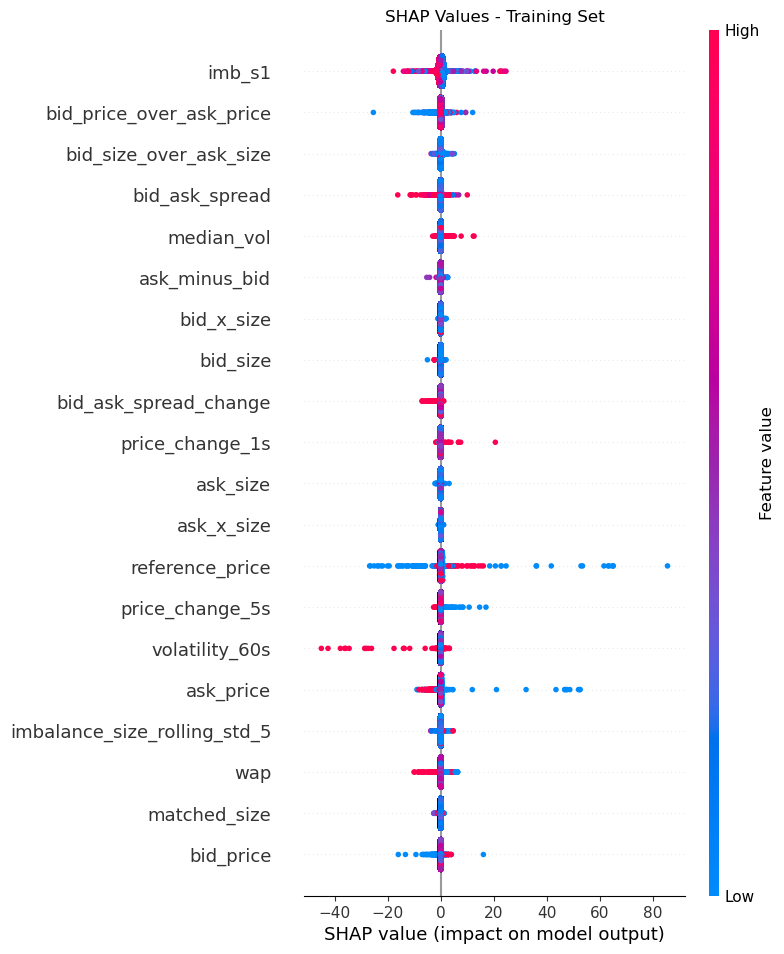

In [24]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_train)

# Summary plot of SHAP values for the training set
shap.summary_plot(shap_values_train, X_train_train, feature_names=X_train_train.columns, show=False)
plt.title("SHAP Values - Training Set")
plt.show()

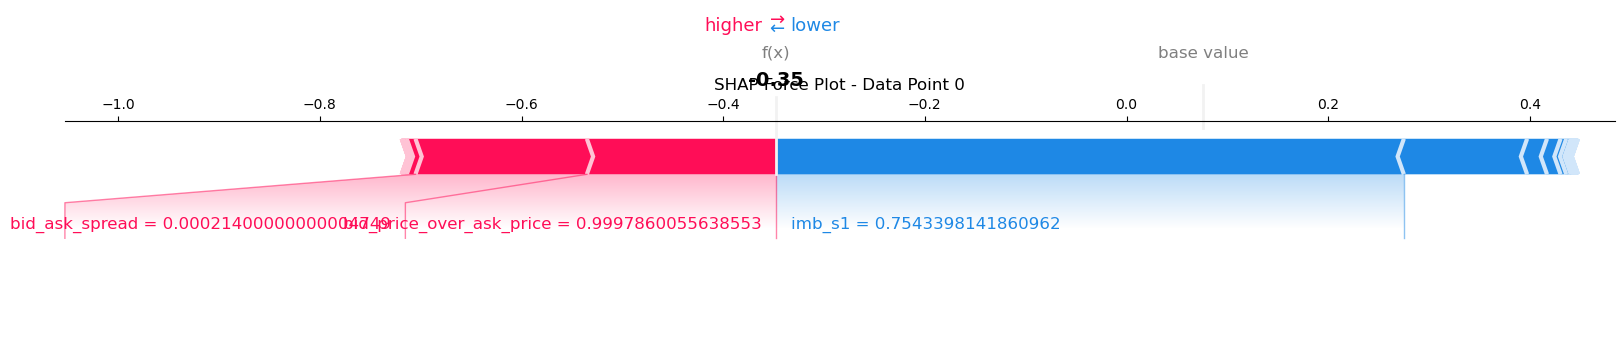

In [25]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Your existing XGBoost code

# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_train)

# Create a force plot for data point 0 using Matplotlib
shap.force_plot(explainer.expected_value, shap_values_train[0, :], X_train_train.iloc[0, :], feature_names=X_train_train.columns, matplotlib=True, show=False)
plt.title("SHAP Force Plot - Data Point 0")
plt.show()

### Hyperparameter Tuning XGBoost using Cross Validation

In [8]:
from sklearn.model_selection import GridSearchCV

In [12]:
from sklearn.model_selection import BaseCrossValidator

class CustomCV(BaseCrossValidator):
    def __init__(self, n_splits=2, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state

    def split(self, df):
        for i in range(self.n_splits):
            if i == 0:
                train_indices = list(df[df['stock_id'] >= 10].index)
                test_indices = list(df[df['stock_id'] < 10].index)
            else:
                train_indices = list(df[df['stock_id'] < 40].index)
                test_indices = list(df[df['stock_id'] >= 40].index)

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


In [15]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Split the data into training and validation sets

dtrain = xgb.DMatrix(X_train_train, label=y_train_train)
dval = xgb.DMatrix(X_train_val, label=y_train_val)

# Define the parameters
params = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
}

num_boost_round = 1000

# Define the custom scorer for GridSearchCV
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline([
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    scoring=mae_scorer,
    cv=CustomCV().split(X_train),
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [19]:
best_params

{'regressor__max_depth': 3, 'regressor__subsample': 1.0}

In [32]:
# Train the final model using the best hyperparameters and early stopping
best_params = {
    'max_depth': 3,
    'subsample': 1.0
}
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=1,
    verbose_eval=True
)

# Evaluate on the training set
y_pred_xgb_train = model.predict(dtrain)
mae_xgb_train = mean_absolute_error(y_train_train, y_pred_xgb_train)
print("XGBoost MAE (Train):", mae_xgb_train)

# Evaluate on the test set
dtest = xgb.DMatrix(X_test_1, label=y_test_1)
y_pred_xgb_test = model.predict(dtest)
mae_xgb_test = mean_absolute_error(y_test_1, y_pred_xgb_test)
print("XGBoost MAE (Test):", mae_xgb_test)

[0]	train-rmse:8.91669	validation-rmse:8.34417
[1]	train-rmse:8.88214	validation-rmse:8.31288
[2]	train-rmse:8.85362	validation-rmse:8.31194
[3]	train-rmse:8.83754	validation-rmse:8.29526
[4]	train-rmse:8.82667	validation-rmse:8.28662
XGBoost MAE (Train): 5.987435891848087
XGBoost MAE (Test): 8.359977748087964


In [33]:
xgb_test_pred = []
xgb_test_scores = []
df_train_all = [df_train, df_train_2, df_train_3]

for i in range(3):
    max_stock_id = df_train_all[i]['stock_id'].max()
    df_temp = df_train_all[i]
    df_train_train = df_temp[df_temp['stock_id'] < max_stock_id]
    df_train_val = df_temp[df_temp['stock_id'] == max_stock_id]

    X_train_train = df_train_train.loc[:, df_train_train.columns!="target"]
    y_train_train = df_train_train["target"]
    X_train_val = df_train_val.loc[:, df_train_val.columns!="target"]
    y_train_val = df_train_val["target"]

    X_train_train, y_train_train = handle_missing_values(X_train_train, y_train_train)
    X_train_train = feature_engineering(X_train_train)

    X_train_val, y_train_val = handle_missing_values(X_train_val, y_train_val)
    X_train_val = feature_engineering(X_train_val)
    
    dtrain = xgb.DMatrix(X_train_train, label=y_train_train)
    dval = xgb.DMatrix(X_train_val, label=y_train_val)

    best_params = {
        'max_depth': 3,
        'subsample': 1.0
    }
    model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=1,
        verbose_eval=True
    )
    
    xgb.plot_importance(model)

    # Evaluate on the test set
    dtest = xgb.DMatrix(X_test_all[i], label=y_test_all[i])
    y_pred_xgb_test = model.predict(dtest)
    mae_xgb_test = mean_absolute_error(y_test_all[i], y_pred_xgb_test)
    print("XGBoost MAE (Test):", mae_xgb_test)
    
    xgb_test_pred.append(y_pred_xgb_test)
    xgb_test_scores.append(mae_xgb_test)

divide by zero encountered in scalar divide


data dimensions: (1322749, 42)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (26455, 42)
Number of NaN values after replacement: 0
[0]	train-rmse:8.79979	validation-rmse:9.10862
[1]	train-rmse:8.75926	validation-rmse:9.08970
[2]	train-rmse:8.73550	validation-rmse:9.07944
[3]	train-rmse:8.71871	validation-rmse:9.07405
[4]	train-rmse:8.70763	validation-rmse:9.07167
[5]	train-rmse:8.69820	validation-rmse:9.07152
[6]	train-rmse:8.69229	validation-rmse:9.07065
[7]	train-rmse:8.68501	validation-rmse:9.06952
[8]	train-rmse:8.67490	validation-rmse:9.06671
[9]	train-rmse:8.66933	validation-rmse:9.06531
[10]	train-rmse:8.66191	validation-rmse:9.06516
[11]	train-rmse:8.65730	validation-rmse:9.06266
XGBoost MAE (Test): 8.359465537043317


divide by zero encountered in scalar divide


data dimensions: (1322749, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (26455, 54)
Number of NaN values after replacement: 0
[0]	train-rmse:8.85204	validation-rmse:11.39918
[1]	train-rmse:8.81176	validation-rmse:11.37740
[2]	train-rmse:8.78782	validation-rmse:11.36934
[3]	train-rmse:8.77091	validation-rmse:11.36115
[4]	train-rmse:8.75990	validation-rmse:11.35804
[5]	train-rmse:8.75049	validation-rmse:11.35753
[6]	train-rmse:8.74464	validation-rmse:11.35611
[7]	train-rmse:8.73730	validation-rmse:11.36218
XGBoost MAE (Test): 4.363425874850096


divide by zero encountered in scalar divide


data dimensions: (1322749, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (26455, 54)
Number of NaN values after replacement: 0
[0]	train-rmse:8.83850	validation-rmse:11.39934
[1]	train-rmse:8.79847	validation-rmse:11.37752
[2]	train-rmse:8.77459	validation-rmse:11.36945
[3]	train-rmse:8.75772	validation-rmse:11.36125
[4]	train-rmse:8.74672	validation-rmse:11.35814
[5]	train-rmse:8.73728	validation-rmse:11.35865
XGBoost MAE (Test): 5.122169698498206


## Random Forest

In [34]:
df_train_short = df[(df['stock_id']<3)]
X_train_short_all = []
y_train_short_all = []
X_test_short_all = []
y_test_short_all = []
for i in range(3):
    df_train_temp = df_train_short[df_train_short['stock_id']!=i]
    df_test_temp = df_train_short[df_train_short['stock_id']==i]

    df_train_temp = df_train_temp.dropna(subset=["target"])
    df_train_temp.reset_index(drop=True, inplace=True)

    df_test_temp = df_test_temp.dropna(subset=["target"])
    df_test_temp.reset_index(drop=True, inplace=True)

    X_train_2 = df_train_temp.loc[:, df_train_temp.columns!="target"]
    y_train_2 = df_train_temp["target"]

    X_test_2 = df_test_temp.loc[:, df_test_temp.columns!="target"]
    y_test_2 = df_test_temp["target"]

    X_train_2, y_train_2 = handle_missing_values(X_train_2, y_train_2)
    X_train_2 = feature_engineering(X_train_2)
    X_train_short_all.append(X_train_2)
    y_train_short_all.append(y_train_2)

    X_test_2, y_test_2 = handle_missing_values(X_test_2, y_test_2)
    X_test_2 = feature_engineering(X_test_2)
    X_test_short_all.append(X_test_2)
    y_test_short_all.append(y_test_2)

divide by zero encountered in scalar divide


data dimensions: (52910, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (26455, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (52910, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (26455, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


data dimensions: (52910, 54)
Number of NaN values after replacement: 0
data dimensions: (26455, 54)
Number of NaN values after replacement: 0


divide by zero encountered in scalar divide


In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_test_pred = []
rf_test_scores = []

for i in range(3):
    X_train_temp = X_train_short_all[i]
    y_train_temp = y_train_short_all[i]
    X_test_temp = X_test_short_all[i]
    y_test_temp = y_test_short_all[i]

    model_rf = RandomForestRegressor(n_estimators=5, random_state=42)
    model_rf.fit(X_train_temp, y_train_temp)

    y_pred_rf_train = model_rf.predict(X_train_temp)
    y_pred_rf_test = model_rf.predict(X_test_temp)

    mae_rf_train = mean_absolute_error(y_train_temp, y_pred_rf_train)
    print(f"Random Forest MAE (Training) {i}:", mae_rf_train)

    mae_rf_test = mean_absolute_error(y_test_temp, y_pred_rf_test)
    print(f"Random Forest MAE (Testing) {i}:", mae_rf_test)

    rf_test_pred.append(y_pred_rf_test)
    rf_test_scores.append(mae_rf_test)

Random Forest MAE (Training) 0: 3.3457594383128337
Random Forest MAE (Testing) 0: 6.18589266951318
Random Forest MAE (Training) 1: 2.462473180608108
Random Forest MAE (Testing) 1: 9.380481413482842
Random Forest MAE (Training) 2: 2.6450294789122593
Random Forest MAE (Testing) 2: 8.770621396049668


## KNN

In [37]:
from sklearn.neighbors import KNeighborsRegressor

k_neighbors = 5
knn_test_pred = []
knn_test_scores = []

for i in range(3):
    
    X_train_temp = X_train_short_all[i]
    y_train_temp = y_train_short_all[i]
    X_test_temp = X_test_short_all[i]
    y_test_temp = y_test_short_all[i]

    # X_train_temp = X_train_all[i]
    # y_train_temp = y_train_all[i]
    # X_test_temp = X_test_all[i]
    # y_test_temp = y_test_all[i]

    model_knn = KNeighborsRegressor(n_neighbors=k_neighbors)
    model_knn.fit(X_train_temp, y_train_temp)

    y_pred_knn_train = model_knn.predict(X_train_temp)
    y_pred_knn_test = model_knn.predict(X_test_temp)

    mae_knn_train = mean_absolute_error(y_train_temp, y_pred_knn_train)
    print(f"k-Nearest Neighbors MAE (Training) {i}:", mae_knn_train)

    mae_knn_test = mean_absolute_error(y_test_temp, y_pred_knn_test)
    print(f"k-Nearest Neighbors MAE (Testing) {i}:", mae_knn_test)

    knn_test_pred.append(y_pred_knn_test)
    knn_test_scores.append(mae_knn_test)

k-Nearest Neighbors MAE (Training) 0: 5.963166575123485
k-Nearest Neighbors MAE (Testing) 0: 8.20632130833391
k-Nearest Neighbors MAE (Training) 1: 4.1840951293772095
k-Nearest Neighbors MAE (Testing) 1: 9.915695491210803
k-Nearest Neighbors MAE (Training) 2: 4.557612474092595
k-Nearest Neighbors MAE (Testing) 2: 9.298598164419527


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

k_neighbors = 5
model_knn = KNeighborsRegressor(n_neighbors=k_neighbors)

model_knn.fit(X_train_1, y_train_1)

y_pred_knn_train = model_knn.predict(X_train_1)
y_pred_knn_test = model_knn.predict(X_test_1)

mae_knn_train = mean_absolute_error(y_train_1, y_pred_knn_train)
print("k-Nearest Neighbors MAE (Training):", mae_knn_train)

mae_knn_test = mean_absolute_error(y_test_1, y_pred_knn_test)
print("k-Nearest Neighbors MAE (Testing):", mae_knn_test)

## Results

In [58]:
xgb_test_scores

[8.359465537043317, 4.363425874850096, 5.122169698498206]

In [61]:
lr_test_scores

[8.342784285932435, 4.3537289962532455, 5.105153503883348]

In [60]:
bl_test_scores

[8.416682551080816, 4.378524085178189, 5.178472131142997]

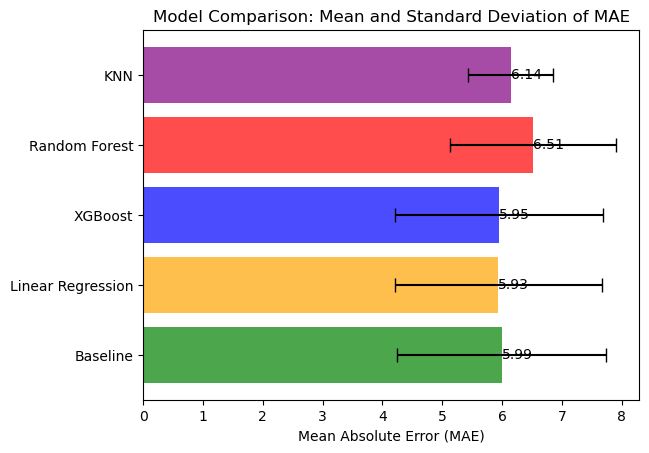

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have lists of scores like bl_test_scores, lr_test_scores, xgb_test_scores, rf_test_scores, knn_test_scores
scores_lists = [bl_test_scores, lr_test_scores, xgb_test_scores, rf_test_scores, knn_test_scores]
labels = ['Baseline', 'Linear Regression', 'XGBoost', 'Random Forest', 'KNN']

# Calculate means and standard deviations
means = [np.mean(scores) for scores in scores_lists]
std_devs = [np.std(scores) for scores in scores_lists]

# Plotting
fig, ax = plt.subplots()

# Plot horizontal bar plot with error bars
ax.barh(labels, means, xerr=std_devs, color=['green', 'orange', 'blue', 'red', 'purple'], alpha=0.7, capsize=5)

# Adding labels and title
ax.set_xlabel('Mean Absolute Error (MAE)')
ax.set_title('Model Comparison: Mean and Standard Deviation of MAE')

# Display values on bars
for i, (mean, std_dev) in enumerate(zip(means, std_devs)):
    ax.text(mean, i, f'{mean:.2f}', va='center', fontsize=10)

plt.show()

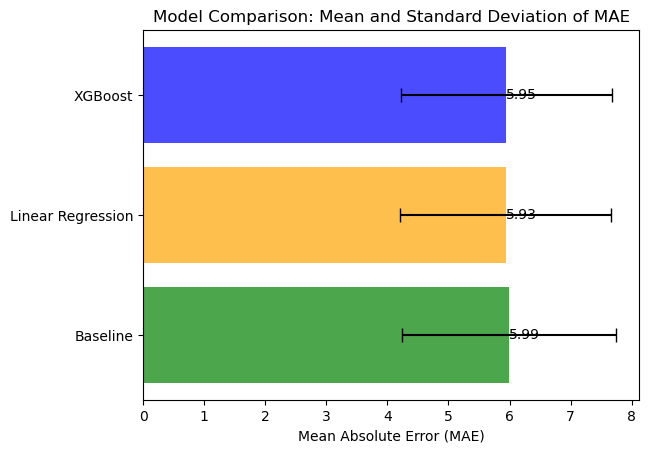

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have lists of scores like bl_test_scores, lr_test_scores, xgb_test_scores
scores_lists = [bl_test_scores, lr_test_scores, xgb_test_scores]
labels = ['Baseline', 'Linear Regression', 'XGBoost']

# Calculate means and standard deviations
means = [np.mean(scores) for scores in scores_lists]
std_devs = [np.std(scores) for scores in scores_lists]

# Plotting
fig, ax = plt.subplots()

# Plot horizontal bar plot with error bars
ax.barh(labels, means, xerr=std_devs, color=['green', 'orange', 'blue'], alpha=0.7, capsize=5)

# Adding labels and title
ax.set_xlabel('Mean Absolute Error (MAE)')
ax.set_title('Model Comparison: Mean and Standard Deviation of MAE')

# Display values on bars
for i, (mean, std_dev) in enumerate(zip(means, std_devs)):
    ax.text(mean, i, f'{mean:.2f}', va='center', fontsize=10)

plt.show()

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)